# Transfer Learning

El **Transfer Learning** es un paradigma que utiliza el conocimiento de un *dominio de origen* (source) para beneficiar a un *dominio de destino* (target) relacionado. Proporciona una alternativa para utilizar un modelo previamente aprendido en nuevos dominios, en lugar de construir un modelo completamente nuevo.

Existen diferentes categorías de Transfer Learning, siendo el *"fine-tuning"* una de las más populares. En este enfoque, se utiliza un modelo preentrenado, comúnmente entrenado con datos genéricos (por ejemplo, una CNN entrenada con el conjunto de datos ImageNet), que luego se ajusta para resolver un problema específico en el dominio de destino. Este enfoque aborda la dificultad de entrenar un modelo completamente desde cero, especialmente cuando el conjunto de datos etiquetados es pequeño, lo que complica el entrenamiento de arquitecturas con un gran número de parámetros, como las CNN.

Para aprovechar el conocimiento de redes pre-entrenadas basadas en arquitecturas de CNN, hay dos enfoques principales:

* **Full Fine-Tuning:** se entrenan todas las capas de la arquitectura preentrenada, incluidas las capas convolucionales y la parte *fully connected*.

* **Feature extraction:** En este enfoque, solo se utilizan las características aprendidas por el modelo preentrenado, lo que implica congelar los parámetros del backbone preentrenado (es decir, estos no se actualizan). Para lograrlo, se congelan las capas convolucionales (**Freezing Layers**) durante el entrenamiento, y únicamente se entrena la parte *fully connected*.

* **Fine-tuning parcial:** solo se entrenan algunas capas convolucionales, junto con la parte *fully connected*.

# Feature extraction using pre-trained CNNs.




In [ ]:
pip install torchmetrics

In [ ]:
pip install torchinfo

In [ ]:
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
import time
from torchinfo import summary
import torchvision
from torchvision.models import list_models
import timm
import os
import torchinfo
torch.manual_seed(0)
torch.cuda.manual_seed(0)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class Transforms:
    def __init__(self, transform: A.Compose):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image)
        return self.transform(image=image)["image"]

train_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)
validation_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = ImageFolder(
    "drive/MyDrive/monkey/training",
    transform=Transforms(train_transforms),
)
validation_data = ImageFolder(
    "drive/MyDrive/monkey/validation",
    transform=Transforms(validation_transforms),
)

print(f"Elementos en Entrenamiento: {len(train_data)}")
print(f"Elementos en Validación: {len(validation_data)}")

Elementos en Entrenamiento: 1097
Elementos en Validación: 272


In [ ]:
#Una pequeña muestra de datos de test a partir de los datos de validación
from torch.utils.data import random_split
# Calcular el tamaño del 20% del conjunto de validación
test_size = int(0.2 * len(validation_data))
validation_size = len(validation_data) - test_size

# Dividir el conjunto de validación en validación (80%) y prueba (20%)
validation_data, test_data = random_split(validation_data, [validation_size, test_size])

# Imprimir el tamaño de cada subconjunto
print(f"Elementos en Entrenamiento: {len(train_data)}")
print(f"Elementos en Validación: {len(validation_data)}")
print(f"Elementos en Prueba: {len(test_data)}")

Elementos en Entrenamiento: 1097
Elementos en Validación: 218
Elementos en Prueba: 54


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**VGG16**

![Descripción de la imagen](https://drive.google.com/uc?export=view&id=167YiD4u4KQ52oZ135DwS_Oif6pIVL0Nb)


In [ ]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, num_classes=10, frozen=True):
        super(VGG16FeatureExtractor, self).__init__()
        self.num_classes = num_classes
        # Cargar VGG16 preentrenado de timm
        self.backbone = timm.create_model('vgg16', pretrained=True, num_classes=0)
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.fc_layers = nn.Sequential(
            nn.LazyLinear(512), #el tamaño de entrada se determina automáticamente
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc_layers(x)
        return x

In [ ]:
# Instanciar el modelo
model = VGG16FeatureExtractor(num_classes=10)
torchinfo.summary(model,input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
VGG16FeatureExtractor                         [1, 10]                   --
├─VGG: 1-1                                    [1, 4096]                 --
│    └─Sequential: 2-1                        [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         (1,792)
│    │    └─ReLU: 3-2                         [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                       [1, 64, 224, 224]         (36,928)
│    │    └─ReLU: 3-4                         [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5                    [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                       [1, 128, 112, 112]        (73,856)
│    │    └─ReLU: 3-7                         [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                       [1, 128, 112, 112]        (147,584)
│    │    └─ReLU: 3-9                         [1, 128, 112, 112]       

In [ ]:
class VGG16Flatten(nn.Module):
    def __init__(self, frozen=True):
        super(VGG16Flatten, self).__init__()
        # Cargar VGG16 preentrenado con la capa de clasificación removida
        self.backbone = timm.create_model('vgg16', pretrained=True, num_classes=0)

        # Congelar los parámetros si frozen=True
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Extraer características y aplanarlas
        features = self.backbone(x)
        #flattened_features = self.flatten(features)
        return features

In [ ]:
feature_extractor = VGG16Flatten()
torchinfo.summary(feature_extractor,input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
VGG16Flatten                                  [1, 4096]                 --
├─VGG: 1-1                                    [1, 4096]                 --
│    └─Sequential: 2-1                        [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         (1,792)
│    │    └─ReLU: 3-2                         [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                       [1, 64, 224, 224]         (36,928)
│    │    └─ReLU: 3-4                         [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5                    [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                       [1, 128, 112, 112]        (73,856)
│    │    └─ReLU: 3-7                         [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                       [1, 128, 112, 112]        (147,584)
│    │    └─ReLU: 3-9                         [1, 128, 112, 112]       

In [ ]:
# Ejemplo de extracción de características
img = "drive/MyDrive/monkey/training/n0/n018.jpg"
img = Image.open(img)
img = np.array(img)
augmented = transforms(image=img)
input_tensor = augmented["image"].unsqueeze(0).to(device)
features = feature_extractor(input_tensor)
print(features.shape)  # Mostrar la forma de las características extraídas

torch.Size([1, 4096])


In [ ]:
features

tensor([[0.0000, 0.2358, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
# Definir las métricas
train_metric = torchmetrics.F1Score(task="multiclass", num_classes=10, average="macro").to(device)
val_metric = torchmetrics.F1Score(task="multiclass", num_classes=10, average="macro").to(device)

In [ ]:
def train_model(
    train_data,
    val_data,
    model,
    training_params,
    criterion=nn.CrossEntropyLoss(),
):
    print(f"Using device: {device}")
    model.to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=training_params["learning_rate"],
    )

    train_dataloader = DataLoader(
        train_data,
        batch_size=training_params["batch_size"],
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size=training_params["batch_size"],
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    train_loss = []
    val_loss = []

    # Configuración para el early stopping
    early_stopping_patience = 10  # Número de épocas sin mejora antes de detener el entrenamiento
    best_val_loss = float('inf')
    patience_counter = 0

    # Directorio para guardar los checkpoints
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    for e in range(training_params["num_epochs"]):
        start_time = time.time()
        train_batch_loss = []
        val_batch_loss = []
        model.train()

        for batch in train_dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            tr_acc = train_metric(y_hat, y)
            train_batch_loss.append(loss.item())

        tr_acc = train_metric.compute()
        train_epoch_loss = np.mean(train_batch_loss)

        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_acc = val_metric(y_hat, y)
                val_batch_loss.append(loss.item())

        val_acc = val_metric.compute()
        val_epoch_loss = np.mean(val_batch_loss)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(
            f"Epoch: {e+1}: Time: {elapsed_time:.2f} - Train Loss: {train_epoch_loss:.4f} - Validation Loss: {val_epoch_loss:.4f} - Train F1: {tr_acc:.4f} - Validation F1: {val_acc:.4f}"
        )

        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)

        # Checkpointing
        if val_epoch_loss < best_val_loss:
          best_val_loss = val_epoch_loss
          patience_counter = 0
          # Guardar el modelo
          checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{e}.pth')
          torch.save(model.state_dict(), checkpoint_path)
          print(f'Model checkpoint saved at epoch {e}')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered at epoch {e-10}. Best validation loss: {best_val_loss:.4f}')
            break

    return model, train_loss, val_loss

In [ ]:
# Configuración de hiperparámetros de entrenamiento
training_params = dict(
    learning_rate=3e-4,
    batch_size=64,
    num_epochs=100,
)

In [ ]:
# Entrenar el modelo utilizando la función `train_model`
ft_vgg16, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    model=model,
    training_params=training_params,
    criterion=nn.CrossEntropyLoss(),
)

Using device: cuda
Epoch: 1: Time: 18.39 - Train Loss: 0.7609 - Validation Loss: 0.2130 - Train F1: 0.7915 - Validation F1: 0.9588
Model checkpoint saved at epoch 0
Epoch: 2: Time: 19.47 - Train Loss: 0.1312 - Validation Loss: 0.1210 - Train F1: 0.8765 - Validation F1: 0.9607
Model checkpoint saved at epoch 1
Epoch: 3: Time: 18.65 - Train Loss: 0.0764 - Validation Loss: 0.1044 - Train F1: 0.9126 - Validation F1: 0.9630
Model checkpoint saved at epoch 2
Epoch: 4: Time: 19.34 - Train Loss: 0.0516 - Validation Loss: 0.1059 - Train F1: 0.9333 - Validation F1: 0.9664
Epoch: 5: Time: 17.61 - Train Loss: 0.0317 - Validation Loss: 0.1073 - Train F1: 0.9462 - Validation F1: 0.9647
Epoch: 6: Time: 17.99 - Train Loss: 0.0216 - Validation Loss: 0.0919 - Train F1: 0.9552 - Validation F1: 0.9667
Model checkpoint saved at epoch 5
Epoch: 7: Time: 19.46 - Train Loss: 0.0146 - Validation Loss: 0.0905 - Train F1: 0.9616 - Validation F1: 0.9681
Model checkpoint saved at epoch 6
Epoch: 8: Time: 19.54 - Tra

In [ ]:
# Crear una nueva instancia del modelo con los mismos parámetros que el modelo original
best_model = VGG16FeatureExtractor(num_classes=10)
checkpoint_path = os.path.join('checkpoints', 'checkpoint_epoch_10.pth')
best_model.load_state_dict(torch.load(checkpoint_path,weights_only=True))
best_model.to(device)

VGG16FeatureExtractor(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

In [ ]:
def testing(model_input, data_eva):
    # Cambiar el modelo al modo de evaluación
    model_input.eval()

    # Inicializar el cálculo de F1-score
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=10, average="macro").to(device)
    data_eva = DataLoader(data_eva,batch_size=training_params["batch_size"],shuffle=False,num_workers=2,pin_memory=True,)
    criterion=nn.CrossEntropyLoss()
    # Desactivar el cálculo de gradientes ya que no necesitamos backpropagation
    with torch.no_grad():
        test_loss = []
        total_samples = 0

        # Iterar sobre el conjunto de datos de test
        for batch in data_eva:
            # Mover los datos al dispositivo adecuado (CPU o GPU)
            features, target = batch[0].to(device), batch[1].to(device)

            # Hacer predicciones con el modelo
            output = model_input(features)
            loss = criterion(output, target.squeeze())  # Asegurarse de que las dimensiones coincidan
            test_loss.append(loss.item())

            # Convertir las predicciones a clases con la probabilidad máxima
            preds = torch.argmax(output, dim=1)

            # Actualizar el cálculo del F1-score
            f1_metric.update(preds, target)

    # Calcular el F1-score final
    f1_score = f1_metric.compute().item()

    print(f'F1-score: {f1_score:.5f}')

In [ ]:
testing(model,test_data)

F1-score: 0.95980


In [ ]:
def ploting(train_loss,val_loss):
  plt.plot(range(len(train_loss)),train_loss,color='blue',label='Train')
  plt.plot(range(len(val_loss)), val_loss,color='red',label='Val')
  plt.legend(title = "Loss")

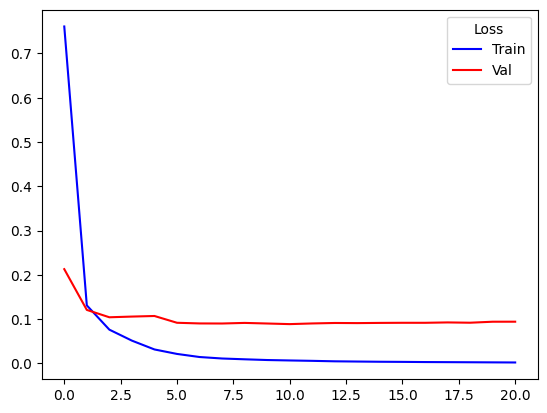

In [ ]:
ploting(train_loss,val_loss)